In [1]:
import struct
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim
from imgaug import augmenters as iaa
from data_process import read_dataset, shuffle_dataset

%load_ext autoreload
%autoreload 2

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [2]:
batch_size = 32
images, labels, images_test, labels_test = read_dataset()

In [15]:
def run_model(session, predict, loss, train_step, saver, images, labels,
              epochs=1, batch_size=64, print_every=100, save_every=10,
              plot_losses=False):

    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict, axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # counter
    iter_cnt = 0
    iters_each_epoch = len(images)//batch_size - 1
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        images, labels = shuffle_dataset(images, labels)
        for i in range(iters_each_epoch):
            current_iter = i+1
            
            batch_X, batch_y = images[current_iter*batch_size:(current_iter+1)*batch_size], labels[current_iter*batch_size:(current_iter+1)*batch_size]
            feed_dict = {X: batch_X, y: batch_y}
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            l, corr, _ = session.run([loss, correct_prediction, train_step],feed_dict=feed_dict)

            # aggregate performance stats
            losses.append(l*batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if (iter_cnt % print_every) == 0:
                print("Iteration {0}/{1}: with minibatch training loss = {2:.3g} and accuracy of {3:.4g}"\
                      .format(iter_cnt, epochs*iters_each_epoch, l, np.sum(corr)/batch_size))
            iter_cnt += 1
        total_correct = correct/len(images)
        total_loss = np.sum(losses)/len(images)
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.4g}".format(total_loss,total_correct,e+1))
        
        if e % save_every == 0:
            saver.save(sess, 'checkpoints/mnist_plus', iter_cnt)
        
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    
    return total_loss,total_correct

In [4]:
# key word for multi-define
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 28, 28, 3])
y = tf.placeholder(tf.int64, [None, 14])

with tf.variable_scope('classifier', reuse=tf.AUTO_REUSE) as scope:
    y_ = slim.conv2d(inputs=X, num_outputs=32, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
    y_ = slim.pool(y_, kernel_size=2, pooling_type='MAX')
    y_ = slim.conv2d(y_, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
    y_ = slim.pool(y_, kernel_size=2, pooling_type='MAX')
    y_ = slim.flatten(y_)
    y_ = tf.layers.dense(y_, 512, activation=tf.nn.relu)
    y_ = tf.layers.dense(y_, 512, activation=tf.nn.relu)
    y_pred = tf.layers.dense(y_, 14)
    
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(y, logits=y_pred))
train_step = tf.train.AdamOptimizer(5e-4).minimize(loss)

no pre-trained model
Iteration 0/7800: with minibatch training loss = 2.66 and accuracy of 0
Iteration 500/7800: with minibatch training loss = 0.304 and accuracy of 0.9062
Epoch 1, Overall loss = 0.402 and accuracy of 0.9045


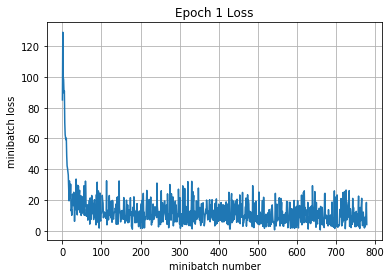

Iteration 1000/7800: with minibatch training loss = 0.0809 and accuracy of 0.9688
Iteration 1500/7800: with minibatch training loss = 0.0641 and accuracy of 1
Epoch 2, Overall loss = 0.267 and accuracy of 0.9431


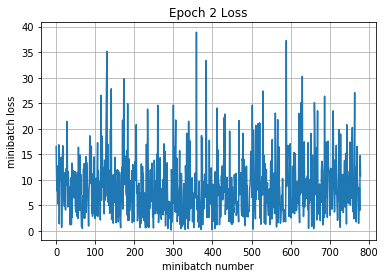

Iteration 2000/7800: with minibatch training loss = 0.0806 and accuracy of 1
Epoch 3, Overall loss = 0.222 and accuracy of 0.9543


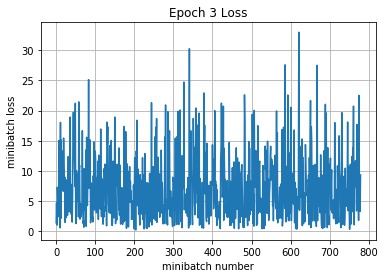

Iteration 2500/7800: with minibatch training loss = 0.0773 and accuracy of 0.9688
Iteration 3000/7800: with minibatch training loss = 0.719 and accuracy of 0.9062
Epoch 4, Overall loss = 0.196 and accuracy of 0.9594


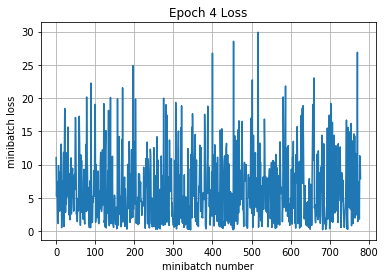

Iteration 3500/7800: with minibatch training loss = 0.0311 and accuracy of 1
Epoch 5, Overall loss = 0.181 and accuracy of 0.9628


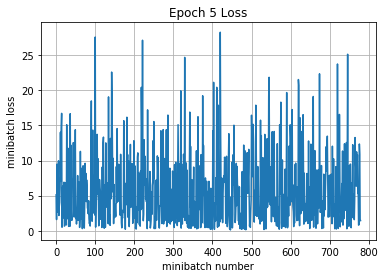

Iteration 4000/7800: with minibatch training loss = 0.0282 and accuracy of 1
Iteration 4500/7800: with minibatch training loss = 0.338 and accuracy of 0.9375
Epoch 6, Overall loss = 0.174 and accuracy of 0.9638


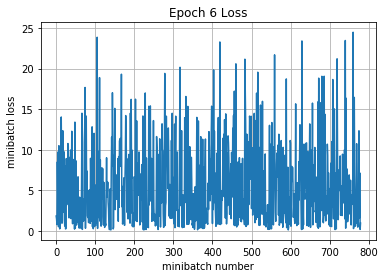

Iteration 5000/7800: with minibatch training loss = 0.401 and accuracy of 0.9375
Epoch 7, Overall loss = 0.169 and accuracy of 0.9658


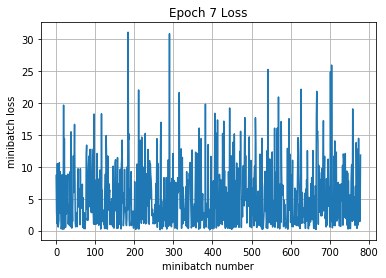

Iteration 5500/7800: with minibatch training loss = 0.0211 and accuracy of 1
Iteration 6000/7800: with minibatch training loss = 0.0128 and accuracy of 1
Epoch 8, Overall loss = 0.164 and accuracy of 0.9659


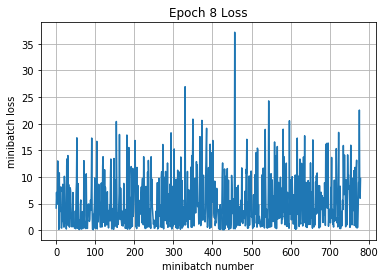

Iteration 6500/7800: with minibatch training loss = 0.0307 and accuracy of 1
Iteration 7000/7800: with minibatch training loss = 0.231 and accuracy of 0.9688
Epoch 9, Overall loss = 0.156 and accuracy of 0.9671


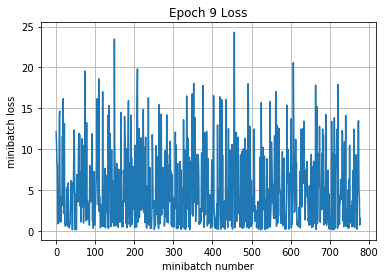

Iteration 7500/7800: with minibatch training loss = 0.0223 and accuracy of 1
Epoch 10, Overall loss = 0.153 and accuracy of 0.9678


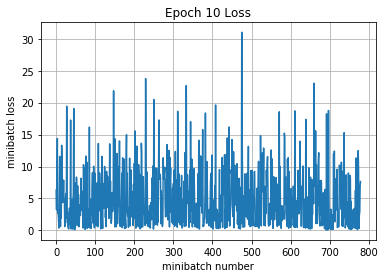

In [16]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    ckpt =  tf.train.get_checkpoint_state(os.path.dirname('checkpoints/condition_comic/checkpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('successfully restore')
    else:
        sess.run(tf.global_variables_initializer())
        print('no pre-trained model')
        
    run_model(sess, y_pred, loss, train_step, saver, images, labels, 10, batch_size, 500, save_every=10, plot_losses=True)